In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp

# _FOLDER = "/home/acq18mk/master/results/results/"
_FOLDER = "/home/juanjo/Work_Postdoc/my_codes_postdoc/DrugProfiles-master/results_with_NonAffecting_Drugs/"

### Coding Part

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
# #columns to normalise:
# with open(_FOLDER+"columns_to_normalise.txt", 'r') as f:
#     columns_to_normalise = [line.rstrip('\n') for line in f]
# # *****************************************

with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

In [2]:
GDSC_Info = pd.read_csv(_FOLDER+"Cell_list_GDSC.csv")  #Contains info of cancer types for both GDSC1 and GDSC2

In [3]:
df_GDSC1 = GDSC_Info[GDSC_Info["Dataset"]=="GDSC1"] 

In [4]:
df_OneCancer = df_GDSC1[df_GDSC1["Tissue"]=="lung"].reset_index()

In [5]:
#df_OneCancer = df_GDSC1.reset_index().copy()

In [6]:
all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

train_df = pd.read_csv(_FOLDER+"train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER+"test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

datasets = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]

X_feat_dict = {"Dataset 1": X_cancer_cell_lines ,
               "Dataset 2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset 3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset 4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

### Coefficient_1

train_drug = train_df_50.copy()
test_drug = test_df_50.copy()
  
data_set = "Dataset 4" 
X_columns = X_feat_dict[data_set]

In [7]:
df_train_drug_new = train_drug[train_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][0]]
for i in range(1,df_OneCancer.shape[0]):
    df_aux = train_drug[train_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][i]]
    df_train_drug_new = pd.concat([df_train_drug_new, df_aux])
    
df_test_drug_new = test_drug[test_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][0]]
for i in range(1,df_OneCancer.shape[0]):
    df_aux = test_drug[test_drug["COSMIC_ID"]==df_OneCancer["COSMICID"][i]]
    df_test_drug_new = pd.concat([df_test_drug_new, df_aux])

In [8]:
df_train_drug_new = df_train_drug_new.reset_index()
df_test_drug_new = df_test_drug_new.reset_index()

In [9]:
scaler = MinMaxScaler().fit(df_train_drug_new[X_columns])
Xtrain_drug = scaler.transform(df_train_drug_new[X_columns])
Xtest_drug = scaler.transform(df_test_drug_new[X_columns])

y_train_drug = np.clip(df_train_drug_new["norm_cells_"+str(1)].values[:,None],1.0e-9,1.0)
y_test_drug =  np.clip(df_test_drug_new["norm_cells_"+str(1)].values[:,None],1.0e-9,1.0)
print(y_train_drug.shape)
for i in range(2,10):
    y_train_drug = np.concatenate((y_train_drug,np.clip(df_train_drug_new["norm_cells_"+str(i)].values[:,None],1.0e-9,1.0)),1)
    y_test_drug = np.concatenate((y_test_drug,np.clip(df_test_drug_new["norm_cells_"+str(i)].values[:,None],1.0e-9,1.0)),1)

(9108, 1)


In [10]:
params_4_sig_train = df_train_drug_new["param_"+str(1)].values[:,None]
params_4_sig_test = df_test_drug_new["param_"+str(1)].values[:,None]
for i in range(2,5):
    params_4_sig_train = np.concatenate((params_4_sig_train,df_train_drug_new["param_"+str(i)].values[:,None]),1)
    params_4_sig_test = np.concatenate((params_4_sig_test,df_test_drug_new["param_"+str(i)].values[:,None]),1)

In [11]:
### Training data for the GP ###
output_dim = y_train_drug.shape[1]
N_per_out = Xtrain_drug.shape[0]
Xall = Xtrain_drug.copy()  #
Yall = y_train_drug.copy()

### Testing data for the GP ###
N_per_out_test = Xtest_drug.shape[0]
Xtest = Xtest_drug.copy()  #
Ytest = y_test_drug.copy()

In [12]:
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

In [13]:
Yall.shape

(9108, 9)

1.0
1.0


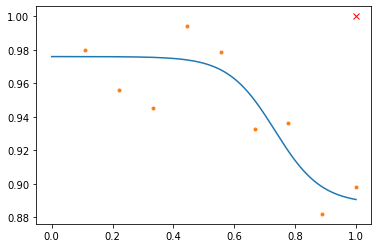

In [14]:
import matplotlib.pyplot as plt
x_lin = np.linspace(0,1,1000)
x_real_dose = np.linspace(0.111,1,9)
x_lin_tile = np.tile(x_lin,(params_4_sig_train.shape[0],1))
#(x_lin,params_4_sig_train.shape[0],1).shape
Ydose_res = []
IC50 = []
Ydose50 = []
for i in range(params_4_sig_train.shape[0]):
    Ydose_res.append(sigmoid_4_param(x_lin_tile[i,:],*params_4_sig_train[i,:]))
    res1=(Ydose_res[i]<0.507)
    res2=(Ydose_res[i]>0.493)
    if (res1 & res2).sum()>0:
        Ydose50.append(Ydose_res[i][res1 & res2].mean())
        IC50.append(x_lin[res1 & res2].mean())
    else:
        Ydose50.append(x_lin[-1])
        IC50.append(x_lin[-1])

posy = 30        
plt.plot(x_lin,Ydose_res[posy])
plt.plot(x_real_dose,Yall[posy,:],'.')
plt.plot(IC50[posy],Ydose50[posy],'rx')
print(IC50[posy])
print(Ydose50[posy])

#x_lin_tile.shape


In [15]:
IC50 = np.array(IC50)

95.4358423235212

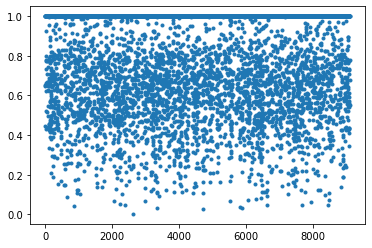

In [16]:
plt.plot(IC50,'.')
IC50.shape[0]**0.5

In [17]:
#df_train_drug_new["COSMIC_ID"]
df_cosmic_train = df_train_drug_new[['COSMIC_ID','DRUG_ID']]
df_group_train = df_cosmic_train.groupby("DRUG_ID")['COSMIC_ID'].unique()
myarray_train = df_group_train.values
for i in range(myarray_train.shape[0]):
    if i==0:
        myset = {value for value in myarray_train[i]}
    else:
        myset = myset.union({value for value in myarray_train[i]})

In [18]:
df_cosmic_test = df_test_drug_new[['COSMIC_ID','DRUG_ID']]
df_group_test = df_cosmic_test.groupby("DRUG_ID")['COSMIC_ID'].unique()
myarray_test = df_group_test.values
for i in range(myarray_test.shape[0]):
    myset = myset.union({value for value in myarray_test[i]})

In [19]:
len(myset)
#myset

194

In [20]:
df_drugID_train = df_train_drug_new[['COSMIC_ID','DRUG_ID']]
df_groupDrugID_train = df_drugID_train.groupby("COSMIC_ID")['DRUG_ID'].unique()
myarray_Drug_train = df_groupDrugID_train.values
for i in range(myarray_Drug_train.shape[0]):
    if i==0:
        myset_Drug = {value for value in myarray_Drug_train[i]}
    else:
        #print(len({value for value in myarray_Drug[i]}))
        aux_set = {value for value in myarray_Drug_train[i]}
        myset_Drug = myset_Drug.union(aux_set.copy())

In [21]:
df_drugID_test = df_test_drug_new[['COSMIC_ID','DRUG_ID']]
df_groupDrugID_test = df_drugID_test.groupby("COSMIC_ID")['DRUG_ID'].unique()
myarray_Drug_test = df_groupDrugID_test.values
for i in range(myarray_Drug_test.shape[0]):
    aux_set = {value for value in myarray_Drug_test[i]}
    myset_Drug = myset_Drug.union(aux_set.copy())

In [22]:
#myarray_Drug[5]
len(myset_Drug)
#myset_Drug
#df_groupDrugID_train.values[1].shape
#194*208
#139*790

208

In [48]:
# for i in range(len(myset_Drug)):
#     for j in range(len(myset)):
IC50_matrix = np.nan* np.zeros((len(myset_Drug),len(myset)))
list_DrugID = list(myset_Drug)
list.sort(list_DrugID)
mydict_drug = dict(zip(list_DrugID,list(np.arange(0,len(myset_Drug))))) 

list_CosmicID = list(myset)
list.sort(list_CosmicID)
mydict_cosmic = dict(zip(list_CosmicID,list(np.arange(0,len(myset))))) 

for i in range(Yall.shape[0]):
    ind_row = mydict_drug[df_train_drug_new["DRUG_ID"][i]]
    ind_col = mydict_cosmic[df_train_drug_new["COSMIC_ID"][i]]
    #print(ind_row,ind_col)
    IC50_matrix[ind_row,ind_col] = IC50[i].copy()
    #print(IC50[i])

In [50]:
#mydict_cosmic
#mydict_drug
print("Total matrix positions:",IC50_matrix.shape[0]*IC50_matrix.shape[1])
print("missing values:",(IC50_matrix==0.0).sum())

IC50_matrix[1,:]
#208*194
#208*984
#IC50
#Yall.shape[0]
#155596/204672
#plt.plot(IC50,'x')
#IC50.shape[0]**0.5
#IC50_matrix
#plt.figure(figsize=(10,20))
#plt.imshow(IC50_matrix)

Total matrix positions: 40352
missing values: 0


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 1.        ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 1.        ,
       1.        , 1.        ,        nan,        nan, 1.        ,
       1.        ,        nan,        nan,        nan,        nan,
              nan, 1.        , 1.        , 1.        ,        nan,
              nan,        nan, 1.        ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 1.        ,
       1.        ,        nan, 1.        ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 1.        ,
              nan,        nan,        nan, 1.        , 1.     

In [51]:
#IC50_matrix_copy = IC50_matrix.copy()
IC50_matrix_copy[1,:]
#plt.figure(figsize=(10,20))
#plt.imshow(IC50_matrix_copy)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 1.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 1.     

In [55]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
from sklearn.model_selection import KFold, cross_val_score
Xind = np.arange(N_per_out)
k_fold = KFold(n_splits=5,shuffle=True,random_state=0)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Nfold = 0
select_fold = 0
for train_id, val_id in k_fold.split(Xind):
    if Nfold == select_fold:
        print(f"Using Fold {Nfold}")
        Xval = Xall[val_id, :].copy()
        Xtrain = Xall[train_id, :].copy()
        Yval = Yall[val_id, :].copy()
        Ytrain = Yall[train_id, :].copy()
        break
    Nfold +=1

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

Using Fold 0


'\n'

In [56]:
print("Training Y shape:", Ytrain.shape)
print("Training X shape:", Xtrain.shape)
print("Validation Y shape:", Yval.shape)
print("Validation X shape:", Xval.shape)

Training Y shape: (39260, 9)
Training X shape: (39260, 1352)
Validation Y shape: (9816, 9)
Validation X shape: (9816, 1352)


In [57]:
# path_to_save = "/home/juanjo/Work_Postdoc/Bench_Mark_DrugResponse_Models/Functional-Random-forest-master/"
# np.savetxt(path_to_save+"Xtrain.csv", Xtrain, delimiter=",")
# np.savetxt(path_to_save+"Ytrain.csv", Ytrain, delimiter=",")
# np.savetxt(path_to_save+"Xtest.csv", Xtest, delimiter=",")
# np.savetxt(path_to_save+"Ytest.csv", Ytest, delimiter=",")

In [58]:
df_train_drug_new.columns[0:30]

Index(['DRUG_ID', 'COSMIC_ID', 'MAX_CONC', 'fd_num_0', 'fd_num_1', 'fd_num_2',
       'fd_num_3', 'fd_num_4', 'fd_num_5', 'fd_num_6', 'fd_num_7', 'fd_num_8',
       'fd_num_9', 'norm_cells_0', 'norm_cells_1', 'norm_cells_2',
       'norm_cells_3', 'norm_cells_4', 'norm_cells_5', 'norm_cells_6',
       'norm_cells_7', 'norm_cells_8', 'norm_cells_9', 'param_1', 'param_2',
       'param_3', 'param_4', 'ABCB1_mut', 'ABL2_mut', 'ACACA_mut'],
      dtype='object')

In [59]:
df_Cell_Lines = pd.read_csv("/home/juanjo/Work_Postdoc/my_codes_postdoc/DrugProfiles-master/data/Cell_Lines_Details.csv") 

In [60]:
list_check_CosmicID = list(df_Cell_Lines["COSMIC identifier"].values)
set_check_CosmicID = set(list_check_CosmicID)
len(set_check_CosmicID)

1001

In [61]:
df_norm_dose_res = pd.read_csv("/home/juanjo/Work_Postdoc/my_codes_postdoc/DrugProfiles-master/data/normalised_dose_response_data.csv") 
#df_norm_dose_res = df_norm_dose_res.dropna()
df_norm_dose_res

,Unnamed: 0,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,...,per_slope_change_7,slope_0,slope_1,slope_2,slope_3,slope_4,slope_5,slope_6,slope_7,slope_8
0,0,HDQ-P1,1290922,332,332_1290922,2,10.240,0,0.111111,0.222222,...,-2.146936,0.354085,-0.371905,0.069255,0.450075,-0.049503,-0.131784,0.246947,-1.239447,1.421566
1,1,HDQ-P1,1290922,257,257_1290922,2,10.240,0,0.111111,0.222222,...,-30.328283,-0.275239,0.163481,0.586129,0.180903,-0.221430,-0.349017,0.157822,0.087103,-2.554585
2,2,HDQ-P1,1290922,245,245_1290922,2,40.000,0,0.111111,0.222222,...,-0.618543,-0.394857,-0.615137,0.485215,-0.923687,0.466260,2.837371,-5.409070,-3.468825,-1.323207
3,3,HDQ-P1,1290922,155,155_1290922,2,0.512,0,0.111111,0.222222,...,1.145906,0.791510,-0.964611,1.238764,1.046952,-0.652559,-1.921061,-0.541266,-0.480877,-1.031916
4,4,HDQ-P1,1290922,192,192_1290922,2,16.000,0,0.111111,0.222222,...,1.533549,0.317413,0.044115,-0.604783,0.510820,-0.431190,0.575779,2.380415,-0.793585,-2.010587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225379,225376,SK-MEL-1,909723,1091,1091_909723,4,4.000,0,0.200000,0.400000,...,NaN,-0.148396,-0.527321,2.309759,-1.130448,0.080796,NaN,NaN,NaN,NaN
225380,225377,TT2609-C02,1240223,1529,1529_1240223,4,1.000,0,0.200000,0.400000,...,NaN,-3.354157,-0.223255,4.021880,0.008650,0.070483,NaN,NaN,NaN,NaN
225381,225378,HCC1806,907047,1230,1230_907047,4,0.100,0,0.200000,0.400000,...,NaN,-0.426862,-0.370866,1.381096,-0.102575,0.057684,NaN,NaN,NaN,NaN
225382,225380,KARPAS-45,907272,1219,1219_907272,4,10.000,0,0.200000,0.400000,...,NaN,-0.576563,0.576754,0.259399,-1.309570,-3.258550,NaN,NaN,NaN,NaN


In [62]:
#Here we check how many COSMIC_ID we have in the file
#normalised_dose_response_data.csv
list_check_CosmicID_again = list(df_norm_dose_res["COSMIC_ID"].values)
set_check_CosmicID_again = set(list_check_CosmicID_again)
len(set_check_CosmicID_again)

1074

In [63]:
#Here we check how many DRUG_ID we have in the file
#normalised_dose_response_data.csv
list_check_DrugID_again = list(df_norm_dose_res["DRUG_ID"].values)
set_check_DrugID_again = set(list_check_DrugID_again)
len(set_check_DrugID_again)

265

In [67]:
print("Number of data we should expect", len(set_check_DrugID_again)*len(set_check_CosmicID_again))
print("Number of data in data frame",df_norm_dose_res.shape[0])
225384/284610
#284610**0.5

Number of data we should expect 284610
Number of data in data frame 225384


0.791904711710762

In [250]:
ind_plateu_1 = df_norm_dose_res[df_norm_dose_res.columns[25:26]]<0.5 
ind_plateu_2 = df_norm_dose_res[df_norm_dose_res.columns[26:27]]<0.5
#ind_plateu_1.values & ind_plateu_2.values
df_drug_affect = df_norm_dose_res[ind_plateu_1.values & ind_plateu_2.values]
#df_norm_dose_res[df_norm_dose_res.columns[25:27]<0.5]

In [251]:
#df_drug_affect[df_drug_affect.columns[17:27]]

#Here we check how many COSMIC_ID we have in the file
#normalised_dose_response_data.csv
list_check_CosmicID_affect = list(df_drug_affect["COSMIC_ID"].values)
set_check_CosmicID_affect = set(list_check_CosmicID_affect)
len(set_check_CosmicID_affect)

1064

In [252]:
#Here we check how many DRUG_ID we have in the file
#normalised_dose_response_data.csv
list_check_DrugID_affect = list(df_drug_affect["DRUG_ID"].values)
set_check_DrugID_affect = set(list_check_DrugID_affect)
len(set_check_DrugID_affect)

218

In [253]:
print("Number of data we should expect", len(set_check_DrugID_affect)*len(set_check_CosmicID_affect))
print("Number of data in data frame",df_drug_affect.shape[0])

Number of data we should expect 231952
Number of data in data frame 47026


In [254]:
len(list_check_CosmicID_affect)

47026

In [255]:
df_drug_affect["DRUG_ID"]

2          245
5          134
13         344
16         172
20         157
          ... 
191530    1024
191534    1024
191540    1058
191558    1050
191605     176
Name: DRUG_ID, Length: 47026, dtype: int64

In [68]:
CosmicID_values = df_norm_dose_res["COSMIC_ID"].values
set_CosmicID_values = list(set(list(CosmicID_values)))
set_CosmicID_values.sort()
mydict_CosmicID_check = dict(zip(set_CosmicID_values,list(np.zeros(len(set_CosmicID_values)))))
for i in range(CosmicID_values.shape[0]):
    mydict_CosmicID_check[CosmicID_values[i]]+=1.0

In [69]:
small_num_drugs = 1000
max_num_drugs = 0
key_drug_small = ''
key_drug_max = ''
my_vals = []
for key,val in mydict_CosmicID_check.items():
    my_vals.append(val)
    if small_num_drugs>val:
        small_num_drugs = val
        key_drug_small = key
    if max_num_drugs<val:
        max_num_drugs = val
        key_drug_max = key
        #print(val)
    #len(set_CosmicID_values)

In [70]:
print(f"The key {key_drug_max} was tested in as many as {max_num_drugs} drugs")
print(f"The key {key_drug_small} was tested in only {small_num_drugs} drugs")

The key 684057 was tested in as many as 265.0 drugs
The key 924241 was tested in only 1.0 drugs


650
(1074,)
0.9003724394785847


(array([  2.,   5.,   5.,   8.,   5.,   5.,  37.,  20.,   4.,  15.,   5.,
         12.,  66.,  67.,  67.,  55., 320.,  26.,  43., 307.]),
 array([  1. ,  14.2,  27.4,  40.6,  53.8,  67. ,  80.2,  93.4, 106.6,
        119.8, 133. , 146.2, 159.4, 172.6, 185.8, 199. , 212.2, 225.4,
        238.6, 251.8, 265. ]),
 <BarContainer object of 20 artists>)

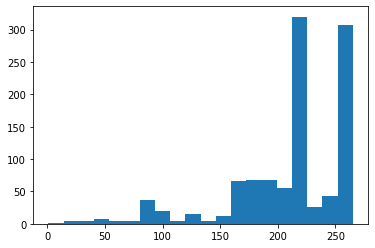

In [71]:
my_vals = np.array(my_vals)
print(((my_vals>150) & (my_vals<250)).sum())
print(my_vals.shape)
print((my_vals>135).sum()/my_vals.shape[0])
plt.hist(my_vals,bins=20)

Text(0.5, 1.0, 'Number of Drugs tested per cell line')

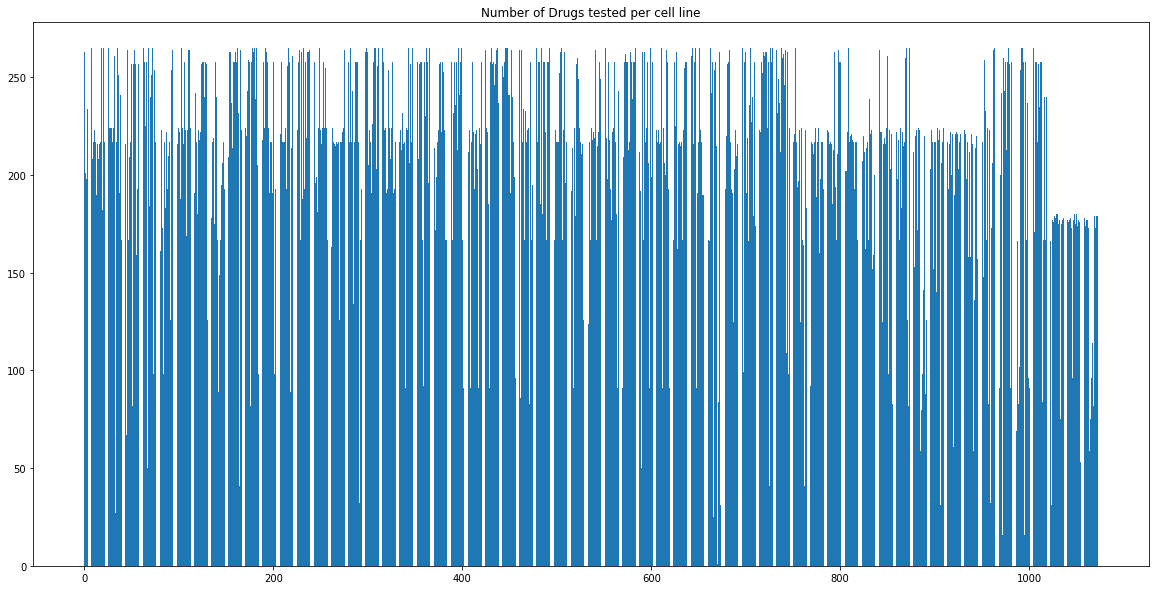

In [85]:
#mydict_CosmicID_check
plt.figure(figsize=(20,10))
plt.bar(np.arange(0,my_vals.shape[0]),my_vals)
#plt.xlim([0,100])
#np.mean(my_vals)
plt.title("Number of Drugs tested per cell line")

In [69]:
#df_train_drug_new["COSMIC_ID"]
X_columns_CosmicID_DrugID = ["COSMIC_ID","DRUG_ID"]+ X_columns
#X_columns_CosmicID_DrugID
df_train_X = df_train_drug_new[X_columns_CosmicID_DrugID]
df_train_X
#df_train_X
df_group_train_X_cells = df_train_X.drop_duplicates(subset ="COSMIC_ID")
df_group_train_X_cells
# myarray_train = df_group_train.values
# for i in range(myarray_train.shape[0]):
#     if i==0:
#         myset = {value for value in myarray_train[i]}
#     else:
#         myset = myset.union({value for value in myarray_train[i]})

,COSMIC_ID,DRUG_ID,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,687596,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
52,687600,5,8.000,398.50,8.0,0.0,2.6,0.0,77.2,636.0,...,0,0,0,0,0,0,0,0,0,0
95,687777,134,16.000,588.60,7.0,0.0,0.6,0.0,161.0,969.0,...,0,0,0,0,0,0,0,0,0,0
124,687780,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
183,687787,134,16.000,588.60,7.0,0.0,0.6,0.0,161.0,969.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,1330964,1006,2.000,243.22,3.0,0.0,-2.1,0.0,129.0,383.0,...,0,0,0,0,0,0,0,0,0,0
8967,1330972,3,0.100,914.20,9.0,0.0,6.0,0.0,195.0,1760.0,...,0,0,0,0,0,0,0,0,0,0
9025,1330973,1026,1.000,585.70,10.0,0.0,2.6,0.0,166.0,1210.0,...,0,0,0,0,0,0,0,0,0,0
9030,1503369,152,16.000,349.30,10.0,0.0,1.8,0.0,114.0,470.0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
X_columns_drugs = ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway
X_columns_cells = X_cancer_cell_lines

In [72]:
df_train_X_CellLines =  df_group_train_X_cells[X_columns_cells]
df_train_X_CellLines

,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


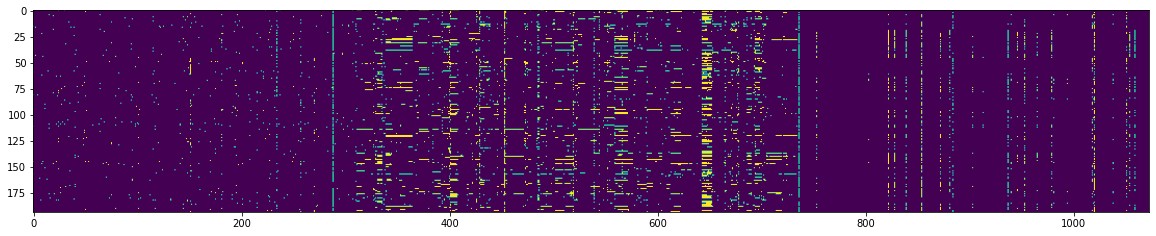

In [75]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_CellLines)

In [80]:
#X_columns_CosmicID_DrugID = ["COSMIC_ID","DRUG_ID"]+ X_columns
#df_train_X = df_train_drug_new[X_columns_CosmicID_DrugID]
#df_train_X
df_group_train_X_drugs = df_train_X.drop_duplicates(subset ="DRUG_ID")
df_group_train_X_drugs

,COSMIC_ID,DRUG_ID,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,687596,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
1,687596,135,1.024,263.20,3.0,0.0,-1.5,0.0,108.0,426.0,...,0,0,0,0,0,0,0,0,0,0
2,687596,136,16.000,334.33,5.0,0.0,-0.4,0.0,147.0,757.0,...,0,0,0,0,0,0,0,0,0,0
3,687596,140,0.064,778.90,12.0,0.0,3.6,0.0,134.0,1690.0,...,0,0,0,0,0,0,0,0,0,0
4,687596,151,10.240,567.70,16.0,0.0,7.6,0.0,85.1,842.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,687997,306,10.240,524.70,11.0,0.0,4.8,0.0,117.0,787.0,...,0,0,0,0,0,0,0,0,0,0
1108,687997,1025,10.000,371.20,10.0,0.0,3.9,0.0,51.1,621.0,...,0,0,0,0,0,0,0,0,0,0
1380,688013,94,10.000,364.40,8.0,0.0,1.9,0.0,57.2,710.0,...,0,0,0,0,0,0,0,0,0,0
1423,688013,1061,5.000,453.50,12.0,0.0,2.1,0.0,78.3,1080.0,...,0,0,0,0,0,0,0,0,0,0


(194, 1073)

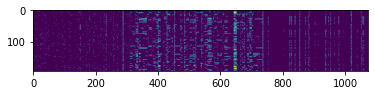

In [103]:
scaler_cells = MinMaxScaler().fit(df_train_X_CellLines)
X_cells_features = scaler_cells.transform(df_train_X_CellLines)
#Xtest_drug = scaler.transform(df_test_drug_new[X_columns])
plt.imshow(X_cells_features)
X_cells_features.shape

In [111]:
Matrix_cells_corr = np.corrcoef(X_cells_features)
print(np.corrcoef(X_cells_features[0,:],X_cells_features[1,:]))

[[1.         0.37397485]
 [0.37397485 1.        ]]


In [114]:
Matrix_cells_corr

array([[1.        , 0.37397485, 0.1204981 , ..., 0.28290845, 0.26740543,
        0.01569487],
       [0.37397485, 1.        , 0.11356118, ..., 0.24161317, 0.37865103,
        0.3104968 ],
       [0.1204981 , 0.11356118, 1.        , ..., 0.14244564, 0.14988251,
        0.22996927],
       ...,
       [0.28290845, 0.24161317, 0.14244564, ..., 1.        , 0.09453401,
        0.13423473],
       [0.26740543, 0.37865103, 0.14988251, ..., 0.09453401, 1.        ,
        0.11962363],
       [0.01569487, 0.3104968 , 0.22996927, ..., 0.13423473, 0.11962363,
        1.        ]])

In [90]:
#df_group_train_X_drugs.sort_values("DRUG_ID")
#plt.plot(df_group_train_X_drugs["DRUG_ID"])
#plt.plot(df_group_train_X_drugs.sort_values("DRUG_ID"))
df_group_train_X_drugs_sorted = df_group_train_X_drugs.sort_values("DRUG_ID").reset_index()

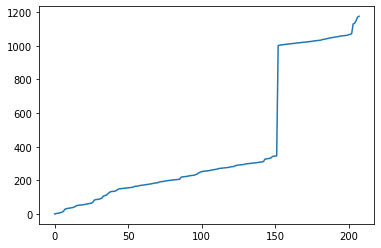

In [91]:
plt.plot(df_group_train_X_drugs_sorted["DRUG_ID"])

In [92]:
df_train_X_Drugs =  df_group_train_X_drugs_sorted[X_columns_drugs]
df_train_X_Drugs

,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,h_bond_donor_count,h_bond_acceptor_count,...,DNA replication,Hormone-related,Genome integrity,WNT signaling,JNK and p38 signaling,Chromatin other,Metabolism,Apoptosis regulation,Chromatin histone methylation,p53 pathway
0,2.0,393.4,8.0,1.0,3.3,0.0,74.7,525.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,0.1,914.2,9.0,0.0,6.0,0.0,195.0,1760.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,398.5,8.0,0.0,2.6,0.0,77.2,636.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,641.6,13.0,0.0,5.0,0.0,111.0,1180.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,475.6,7.0,0.0,4.8,0.0,114.0,644.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,10.0,390.4,7.0,0.0,3.2,0.0,60.9,510.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
204,10.0,328.4,10.0,0.0,4.6,0.0,52.7,387.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
205,5.0,573.7,15.0,0.0,7.8,0.0,132.0,963.0,4.0,6.0,...,0,0,0,0,0,0,0,1,0,0
206,10.0,352.4,8.0,0.0,3.7,0.0,87.6,479.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0


(208, 279)

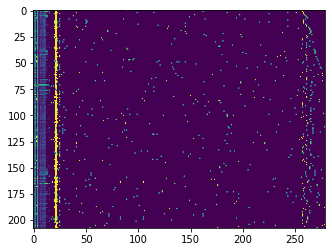

In [102]:
scaler_drugs = MinMaxScaler().fit(df_train_X_Drugs)
X_drug_features = scaler_drugs.transform(df_train_X_Drugs)
#Xtest_drug = scaler.transform(df_test_drug_new[X_columns])

plt.imshow(X_drug_features)
X_drug_features.shape

In [110]:
Matrix_drug_corr = np.corrcoef(X_drug_features)
print(np.corrcoef(X_drug_features[0,:],X_drug_features[1,:]))

[[1.         0.42778051]
 [0.42778051 1.        ]]


In [109]:
Matrix_drug_corr

array([[1.        , 0.42778051, 0.31725519, ..., 0.41879327, 0.50409128,
        0.40763753],
       [0.42778051, 1.        , 0.3086322 , ..., 0.41507195, 0.46822864,
        0.36990667],
       [0.31725519, 0.3086322 , 1.        , ..., 0.28548114, 0.35360304,
        0.40663241],
       ...,
       [0.41879327, 0.41507195, 0.28548114, ..., 1.        , 0.46355803,
        0.37038302],
       [0.50409128, 0.46822864, 0.35360304, ..., 0.46355803, 1.        ,
        0.45638295],
       [0.40763753, 0.36990667, 0.40663241, ..., 0.37038302, 0.45638295,
        1.        ]])